Notes:
sigmoid vs. softmax, references:
http://dataaspirant.com/2017/03/07/difference-between-softmax-function-and-sigmoid-function/
https://www.kaggle.com/c/statoil-iceberg-classifier-challenge/discussion/46039

Blog post super useful, on cropping images: https://flyyufelix.github.io/2017/04/16/kaggle-nature-conservancy.html

In [80]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_colwidth= 999

In [81]:
data_dir = './data'
train_json = data_dir+'/train.json'
train = pd.read_json(train_json)

In [82]:
train.columns
train.dtypes
train['inc_angle'] = train['inc_angle'].replace(to_replace='na', value=0)
train.dtypes

band_1         object
band_2         object
id             object
inc_angle     float64
is_iceberg      int64
dtype: object

In [100]:
train.groupby('is_iceberg').count()

,band_1,band_2,id,inc_angle
is_iceberg,,,,
0,851,851,851,851
1,753,753,753,753


In [4]:
train.shape

(1604, 5)

In [136]:
## IMAGE PREPROCESSING
def image_preprocessing(image):
    
    # Normalize the image to [0,255]
    #--------------------------------
    max_arg = np.max(image)
    min_arg = np.min(image)
    img_norm = (image - min_arg) /(max_arg-min_arg) #*(255)
    
    #Gaussian blur
    #--------------------------------
    kernel_size = 3 # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(img_norm, (kernel_size, kernel_size), 0)
    result = blur_gray
    
    return(result)


def process_data(samples_df, training):
    """
    The input is a dataframe 
    For each row in the dataframe, we add a 2 channels image of shape (75,75,2) into X array
    samples_df.is_iceberg is the target
    X, y arrays, that are the output of the function
    
    """
    print('Training mode:', training)
    num_obs = samples_df.shape[0]
    print('Num initial observations in the dataset: ', num_obs)
    #image_url = samples_df.img_url.tolist()
    #angles = samples_df.steering.tolist()

    # Preprocessing for each center image and angle in the data_log dataframe:
    X = []
    X_angle = []
    y = []

    for i in range(num_obs): # num_obs
        arr1 = np.reshape(np.array(samples_df.iloc[i,0]),(75,75))
        arr2 = np.reshape(np.array(samples_df.iloc[i,1]),(75,75))
        arr3 = (arr1 + arr2) / 2
        
        angle = samples_df.iloc[i,3]  ## to add zero treatment!!!
        X_angle.append(angle)
        
        arr1 = image_preprocessing(arr1) #arr1#
        arr2 = image_preprocessing(arr2) #arr2#
        arr3 = image_preprocessing(arr3)
        
        # Stack arrays in sequence depth wise (along third axis).
        image_channels =  np.dstack((arr1,arr2,arr3))
        X.append(image_channels)
        
        if training:
            label = samples_df.iloc[i,4]
            y.append(label)            
 
    X = np.array(X)
    X_angle = np.array(X_angle)
    y = np.array(y)
    print('Len for processed datasets: ',len(X),len(y), X[0].shape)
    
    if training:
        print('Returning data for training the model...')
    else:
        print('Returning data for test dataset')
    return(X,X_angle,y)


In [63]:
from sklearn.preprocessing import LabelBinarizer
n_classes = 2
encoder = LabelBinarizer()
encoder.fit(range(n_classes))
def one_hot_encode(x,n_classes ):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    one_hot = encoder.transform(x)
    if n_classes == 2:
        one_hot = np.hstack((one_hot, 1 - one_hot))
    return(one_hot)


In [84]:
#arr = np.reshape(np.array(train_ship.iloc[i,1]),(75,75))
X, X_angle, y = process_data(train, True)
#y = one_hot_encode(y,2)

Training mode: True
Num initial observations in the dataset:  1604
Len for processed datasets:  1604 1604 (75, 75, 3)


In [47]:
X_angle

array([ 43.9239,  38.1562,  45.2859, ...,   0.    ,   0.    ,   0.    ])

In [65]:
y

array([[0, 1],
       [0, 1],
       [1, 0],
       ..., 
       [0, 1],
       [0, 1],
       [0, 1]])

In [9]:
# Check of number of elements of each class
unique, counts = np.unique(y, return_counts=True)
print (np.asarray((unique, counts)).T)

[[  0 851]
 [  1 753]]


In [184]:
print(y.shape)
y

(1604, 1)


array([[0],
       [0],
       [1],
       ..., 
       [0],
       [0],
       [0]])

In [236]:
print(X.shape)
#X

(1604, 75, 75, 3)


In [24]:
#print(X[0], y[0])
#X[0].shape[0:2]

### Split data into training and test set

In [85]:
#X,y = process_data(train, True)

from sklearn.model_selection import train_test_split
# Split up data into randomized training and test sets
#-----------------------------------------------------
rand_state = np.random.randint(0, 100)
#--- we don't scale, and can use directly X
X_train, X_val, X_angle_train, X_angle_val, y_train, y_val= train_test_split(X, X_angle, y, test_size=0.2, random_state=rand_state)

print('Training vector length:', len(X_train[0]))
print('X_train sample size:', len(X_train))
print('X_angle_train sample size: ', len(X_angle_train))
print('X_val sample size:', len(X_val))


Training vector length: 75
X_train sample size: 1283
X_angle_train sample size:  1283
X_val sample size: 321


### Data AUGMENTATION

In [86]:
def get_augmentation_flipping(img):
    """
    Flippes images, multiplying by -1 the steering angle
    """
    image_flipped = np.fliplr(img)
    #angle_flipped = -angle
    return(image_flipped)

def get_rotation(image_data):
    rows,cols = image_data.shape[0:2]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
    dst = cv2.warpAffine(image_data,M,(cols,rows))
    return(dst)

In [87]:
# Applying  rotations and transformations to each training and validation set:
#---------------------------------------------------------------------------
## Augmentation for training set:  
X_train_flipped = np.empty_like(X_train)
for row in range(X_train.shape[0]):
    X_train_flipped[row,:,:,:] = get_augmentation_flipping(X_train[row])

X_train_rotated = np.empty_like(X_train)
for row in range(X_train.shape[0]):
    X_train_rotated[row,:,:,:] = get_rotation(X_train[row])

# Finally, concatenating flipping and rottations to train set:
X_train_augmented = np.concatenate((X_train, X_train_flipped, X_train_rotated), axis=0)
X_angle_train_augmented = np.concatenate((X_angle_train,X_angle_train,X_angle_train), axis = 0)
y_train_augmented = np.concatenate((y_train, y_train, y_train), axis=0)


X_val_augmented = X_val
X_angle_val_augmented = X_angle_val
y_val_augmented = y_val
print('Dimension for the new training set AUGMENTED: ', X_train_augmented.shape, y_train_augmented.shape)
print('Dimension for the new validation set AUGMENTED: ', X_val_augmented.shape,y_val_augmented.shape)

Dimension for the new training set AUGMENTED:  (3849, 75, 75, 3) (3849,)
Dimension for the new validation set AUGMENTED:  (321, 75, 75, 3) (321,)


In [334]:
#print(X_train_augmented[0])
#print(X_train_augmented[2000])

### MODEL 1 - Basic ARQUITECTURE

In [51]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

#### MODEL ARQUITECTURE: Build layer functions...

In [10]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    layer_1_weight_shape = (conv_ksize[0], conv_ksize[1], x_tensor.get_shape().as_list()[3], conv_num_outputs)
    
    #Convolutional
    conv1_W = tf.Variable(tf.truncated_normal(layer_1_weight_shape, mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(conv_num_outputs))
    conv1   = tf.nn.conv2d(x_tensor, conv1_W, strides=[1, conv_strides[0], conv_strides[1], 1], padding='VALID') + conv1_b
    
    #Dropout
    #conv1 = tf.nn.dropout(conv1, keep_prob)

    #Relu Activation
    conv1 = tf.nn.relu(conv1)
    
    #Pooling. 
    conv1 = tf.nn.max_pool(conv1, ksize=[1, pool_ksize[0], pool_ksize[1], 1], strides=[1, pool_strides[0], pool_strides[1], 1], padding='VALID')
    
    return(conv1) 

## CHECK DIMENSIONS:
test_x = tf.placeholder(tf.float32, [None, 75, 75, 3]) # [None, 32, 32, 3]
test_x = tf.placeholder(tf.float32, [None,  36, 36, 32])
test_x = tf.placeholder(tf.float32, [None,   17, 17, 64])
#test_x = tf.placeholder(tf.float32, [None, 34, 34, 10]) # [None, 32, 32, 3]

conv_num_outputs = 128
conv_ksize = (3, 3)
conv_strides = (1, 1)
pool_ksize = (2, 2)
pool_strides = (2, 2)    
conv = conv2d_maxpool(test_x, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)

print('Output dimensions: ',conv.get_shape().as_list())



Output dimensions:  [None, 7, 7, 128]


In [11]:
from tensorflow.contrib.layers import flatten as flatten_layer

def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    f_layer = flatten_layer(x_tensor)
    return(f_layer)

## CHECK DIMENSIONS:
test_x = tf.placeholder(tf.float32, [None,7, 7, 128]) # [None, 32, 32, 3]
f_layer = flatten(test_x)

print('Output dimensions: ',f_layer.get_shape().as_list())


Output dimensions:  [None, 6272]


In [12]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    mu = 0
    sigma = 0.1

    # Fully Connected layer. Input = x_tensor.get_shape().as_list()[1]. Output = num_outputs.
    fc_W = tf.Variable(tf.truncated_normal(shape=(x_tensor.get_shape().as_list()[1], num_outputs), mean = mu, stddev = sigma))
    fc_b = tf.Variable(tf.zeros(num_outputs))
    fc   = tf.matmul(x_tensor, fc_W) + fc_b
    
    # Activation.
    fc  = tf.nn.relu(fc)
    return(fc)


In [13]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    mu = 0
    sigma = 0.1

    # Fully Connected layer. Input = x_tensor.get_shape().as_list()[1]. Output = num_outputs.
    fc_W = tf.Variable(tf.truncated_normal(shape=(x_tensor.get_shape().as_list()[1], num_outputs), mean = mu, stddev = sigma))
    fc_b = tf.Variable(tf.zeros(num_outputs))
    fc   = tf.matmul(x_tensor, fc_W) + fc_b
    return(fc)


In [14]:
### FIRST ARQUITECTURE: LeNet

def LeNet(x, keep_prob):    

    # Layer 1: Input: 75x75x2. Output:  36, 36, 32. 
    # conv2d + Relu Activation + Pooling
    conv_num_outputs = 32
    conv_ksize = (3, 3)
    conv_strides = (1, 1)
    pool_ksize = (2, 2)
    pool_strides = (2, 2)    
    conv = conv2d_maxpool(x, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    #Dropout
    conv = tf.nn.dropout(conv, keep_prob)
    
    # Layer 2: Input: 36, 36, 32. Output: 17, 17, 64. 
    # conv2d + Relu Activation + Pooling
    conv_num_outputs = 64
    conv_ksize = (3, 3)
    conv_strides = (1, 1)
    pool_ksize = (2, 2)
    pool_strides = (2, 2)    
    conv2 = conv2d_maxpool(conv, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    #Dropout
    conv2 = tf.nn.dropout(conv2, keep_prob)

    # Layer 3: Input:  17, 17, 64. Output: 7, 7, 128. 
    # conv2d + Relu Activation + Pooling
    #conv_num_outputs = 128
    #conv_ksize = (3, 3)
    #conv_strides = (1, 1)
    #pool_ksize = (2, 2)
    #pool_strides = (2, 2)    
    #conv3 = conv2d_maxpool(conv2, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    #Dropout
    #conv3 = tf.nn.dropout(conv3, keep_prob)

    
    # Flatten. Input = 7, 7, 128. Output = 6272.
    f_layer   = flatten(conv2) #conv3
    
    # Apply 2 Fully Connected Layers (with Relu activation)
    #----------------------------------------------    
    # Fully Connected. Input = 6272. Output = 256.
    num_outputs = 64
    fc = fully_conn(f_layer, num_outputs)
    
    #Fully Connected. Input = 1200. Output = 64.
    num_outputs = 16
    fc = fully_conn(fc, num_outputs)  

    # Set this to the number of classes
    # Output funtion: Fully connected layer with No activation. Input = 84. Output = 2
    num_outputs = 2
    logits = output(fc, num_outputs)

    
    return logits

In [15]:
#len(X_train)

In [15]:
##############################
## Build the Neural Network ##
##############################
rate =0.0001
epochs = 20
batch_size = 32


keep_probability = 0.6
print(epochs,batch_size,keep_probability)

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, (None, 75, 75, 3),  name = 'x')
y = tf.placeholder(tf.int32, (None), name = 'y')
keep_prob = tf.placeholder(tf.float32, name = 'keep_prob')
#one_hot_y = tf.one_hot(y, 2)

# Model
logits = LeNet(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=tf.cast(y, tf.float32)))
optimizer = tf.train.AdamOptimizer(learning_rate = rate).minimize(cost) #learning_rate = rate

# Accuracy
predicted = tf.nn.softmax(logits, name= 'predicted')
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.cast(tf.reduce_max(y, reduction_indices=[1]),tf.int64) ) #tf.argmax(y, 1)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

saver = tf.train.Saver()
print('Network built!')


20 32 0.6
Network built!


In [19]:
#print(y_val)
#with tf.Session() as sess:
#    b =tf.cast(tf.reduce_max(y_val, reduction_indices=[1]),tf.int64)  #tf.max(y_val, 1)#tf.cast(y_val, tf.int64)
#    print(b.eval())

## Train the Network

Function train_neural_network does a single optimization. 
The optimization should use optimizer to optimize in session with a feed_dict of the following:

- x for image input
- y for labels
- keep_prob for keep probability for dropout

This function will be called for each batch, so tf.global_variables_initializer() has already been called.

Nothing needs to be returned. This function is only optimizing the neural network.

In [16]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    
    session.run(optimizer, feed_dict={x: feature_batch,
                                    y: label_batch,
                                    keep_prob: keep_probability})

    pass

Function print_stats prints loss and validation accuracy. 

Uses the global variables valid_features and valid_labels to calculate validation accuracy. 

Uses a keep probability of 1.0 to calculate the loss and validation accuracy.

In [17]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    
    # Calculate batch loss and accuracy
    loss = session.run(cost, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: 1.})
    #print(y_val)
    valid_acc = session.run(accuracy, feed_dict={
                x: X_val_augmented,
                y: y_val_augmented,
                keep_prob: 1.})

    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss,valid_acc))

    return(loss, valid_acc)

In [18]:
from sklearn.utils import shuffle

save_model_path = './image_classification'

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    num_samples = len(X_train_augmented)
    loss_training_model = []
    val_acc_training_model  = []
    # Training cycle
    for epoch in range(epochs):
        batch_i = 0
        # Loop over all batches
        for offset in range(0, num_samples, batch_size):
            batch_i +=1
            end = offset + batch_size
            print(batch_i, offset, end, batch_size, num_samples)
            batch_x, batch_y = X_train_augmented[offset:end], y_train_augmented[offset:end]
            #print(batch_x, batch_y)
            train_neural_network(sess, optimizer, keep_probability, batch_x, batch_y)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            #val_acc.append(accuracy.eval())
            loss, valid_acc = print_stats(sess, batch_x, batch_y, cost, accuracy)
            loss_training_model.append(loss)
            val_acc_training_model.append(valid_acc)
    
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)  

1 0 32 32 3849
Epoch  1, CIFAR-10 Batch 1:  Loss:     0.6726 Validation Accuracy: 0.454829
2 32 64 32 3849
Epoch  1, CIFAR-10 Batch 2:  Loss:     0.7023 Validation Accuracy: 0.454829
3 64 96 32 3849
Epoch  1, CIFAR-10 Batch 3:  Loss:     0.6896 Validation Accuracy: 0.457944
4 96 128 32 3849
Epoch  1, CIFAR-10 Batch 4:  Loss:     0.6915 Validation Accuracy: 0.454829
5 128 160 32 3849
Epoch  1, CIFAR-10 Batch 5:  Loss:     0.6920 Validation Accuracy: 0.451713
6 160 192 32 3849
Epoch  1, CIFAR-10 Batch 6:  Loss:     0.6929 Validation Accuracy: 0.451713
7 192 224 32 3849
Epoch  1, CIFAR-10 Batch 7:  Loss:     0.6919 Validation Accuracy: 0.461059
8 224 256 32 3849
Epoch  1, CIFAR-10 Batch 8:  Loss:     0.6915 Validation Accuracy: 0.473520
9 256 288 32 3849
Epoch  1, CIFAR-10 Batch 9:  Loss:     0.6899 Validation Accuracy: 0.482866
10 288 320 32 3849
Epoch  1, CIFAR-10 Batch 10:  Loss:     0.6932 Validation Accuracy: 0.482866
11 320 352 32 3849
Epoch  1, CIFAR-10 Batch 11:  Loss:     0.6888 

Epoch  1, CIFAR-10 Batch 85:  Loss:     0.6898 Validation Accuracy: 0.532710
86 2720 2752 32 3849
Epoch  1, CIFAR-10 Batch 86:  Loss:     0.6908 Validation Accuracy: 0.532710
87 2752 2784 32 3849
Epoch  1, CIFAR-10 Batch 87:  Loss:     0.6857 Validation Accuracy: 0.532710
88 2784 2816 32 3849
Epoch  1, CIFAR-10 Batch 88:  Loss:     0.6913 Validation Accuracy: 0.532710
89 2816 2848 32 3849
Epoch  1, CIFAR-10 Batch 89:  Loss:     0.6806 Validation Accuracy: 0.532710
90 2848 2880 32 3849
Epoch  1, CIFAR-10 Batch 90:  Loss:     0.6853 Validation Accuracy: 0.532710
91 2880 2912 32 3849
Epoch  1, CIFAR-10 Batch 91:  Loss:     0.6870 Validation Accuracy: 0.532710
92 2912 2944 32 3849
Epoch  1, CIFAR-10 Batch 92:  Loss:     0.6796 Validation Accuracy: 0.532710
93 2944 2976 32 3849
Epoch  1, CIFAR-10 Batch 93:  Loss:     0.6814 Validation Accuracy: 0.532710
94 2976 3008 32 3849
Epoch  1, CIFAR-10 Batch 94:  Loss:     0.6872 Validation Accuracy: 0.532710
95 3008 3040 32 3849
Epoch  1, CIFAR-10 B

Epoch  2, CIFAR-10 Batch 48:  Loss:     0.6847 Validation Accuracy: 0.532710
49 1536 1568 32 3849
Epoch  2, CIFAR-10 Batch 49:  Loss:     0.6811 Validation Accuracy: 0.532710
50 1568 1600 32 3849
Epoch  2, CIFAR-10 Batch 50:  Loss:     0.6742 Validation Accuracy: 0.532710
51 1600 1632 32 3849
Epoch  2, CIFAR-10 Batch 51:  Loss:     0.6636 Validation Accuracy: 0.532710
52 1632 1664 32 3849
Epoch  2, CIFAR-10 Batch 52:  Loss:     0.6746 Validation Accuracy: 0.532710
53 1664 1696 32 3849
Epoch  2, CIFAR-10 Batch 53:  Loss:     0.6648 Validation Accuracy: 0.532710
54 1696 1728 32 3849
Epoch  2, CIFAR-10 Batch 54:  Loss:     0.7007 Validation Accuracy: 0.532710
55 1728 1760 32 3849
Epoch  2, CIFAR-10 Batch 55:  Loss:     0.6808 Validation Accuracy: 0.532710
56 1760 1792 32 3849
Epoch  2, CIFAR-10 Batch 56:  Loss:     0.6638 Validation Accuracy: 0.532710
57 1792 1824 32 3849
Epoch  2, CIFAR-10 Batch 57:  Loss:     0.6722 Validation Accuracy: 0.532710
58 1824 1856 32 3849
Epoch  2, CIFAR-10 B

Epoch  3, CIFAR-10 Batch 11:  Loss:     0.6262 Validation Accuracy: 0.532710
12 352 384 32 3849
Epoch  3, CIFAR-10 Batch 12:  Loss:     0.6556 Validation Accuracy: 0.532710
13 384 416 32 3849
Epoch  3, CIFAR-10 Batch 13:  Loss:     0.6530 Validation Accuracy: 0.526480
14 416 448 32 3849
Epoch  3, CIFAR-10 Batch 14:  Loss:     0.6810 Validation Accuracy: 0.526480
15 448 480 32 3849
Epoch  3, CIFAR-10 Batch 15:  Loss:     0.6651 Validation Accuracy: 0.526480
16 480 512 32 3849
Epoch  3, CIFAR-10 Batch 16:  Loss:     0.6302 Validation Accuracy: 0.526480
17 512 544 32 3849
Epoch  3, CIFAR-10 Batch 17:  Loss:     0.6613 Validation Accuracy: 0.523364
18 544 576 32 3849
Epoch  3, CIFAR-10 Batch 18:  Loss:     0.6641 Validation Accuracy: 0.532710
19 576 608 32 3849
Epoch  3, CIFAR-10 Batch 19:  Loss:     0.6579 Validation Accuracy: 0.532710
20 608 640 32 3849
Epoch  3, CIFAR-10 Batch 20:  Loss:     0.6829 Validation Accuracy: 0.529595
21 640 672 32 3849
Epoch  3, CIFAR-10 Batch 21:  Loss:     

Epoch  3, CIFAR-10 Batch 95:  Loss:     0.6676 Validation Accuracy: 0.523364
96 3040 3072 32 3849
Epoch  3, CIFAR-10 Batch 96:  Loss:     0.6164 Validation Accuracy: 0.523364
97 3072 3104 32 3849
Epoch  3, CIFAR-10 Batch 97:  Loss:     0.6130 Validation Accuracy: 0.532710
98 3104 3136 32 3849
Epoch  3, CIFAR-10 Batch 98:  Loss:     0.6667 Validation Accuracy: 0.532710
99 3136 3168 32 3849
Epoch  3, CIFAR-10 Batch 99:  Loss:     0.6551 Validation Accuracy: 0.532710
100 3168 3200 32 3849
Epoch  3, CIFAR-10 Batch 100:  Loss:     0.6642 Validation Accuracy: 0.532710
101 3200 3232 32 3849
Epoch  3, CIFAR-10 Batch 101:  Loss:     0.6541 Validation Accuracy: 0.532710
102 3232 3264 32 3849
Epoch  3, CIFAR-10 Batch 102:  Loss:     0.6812 Validation Accuracy: 0.532710
103 3264 3296 32 3849
Epoch  3, CIFAR-10 Batch 103:  Loss:     0.6485 Validation Accuracy: 0.526480
104 3296 3328 32 3849
Epoch  3, CIFAR-10 Batch 104:  Loss:     0.6387 Validation Accuracy: 0.529595
105 3328 3360 32 3849
Epoch  3,

Epoch  4, CIFAR-10 Batch 58:  Loss:     0.6305 Validation Accuracy: 0.529595
59 1856 1888 32 3849
Epoch  4, CIFAR-10 Batch 59:  Loss:     0.6152 Validation Accuracy: 0.538941
60 1888 1920 32 3849
Epoch  4, CIFAR-10 Batch 60:  Loss:     0.6531 Validation Accuracy: 0.545171
61 1920 1952 32 3849
Epoch  4, CIFAR-10 Batch 61:  Loss:     0.6319 Validation Accuracy: 0.548287
62 1952 1984 32 3849
Epoch  4, CIFAR-10 Batch 62:  Loss:     0.6818 Validation Accuracy: 0.551402
63 1984 2016 32 3849
Epoch  4, CIFAR-10 Batch 63:  Loss:     0.5919 Validation Accuracy: 0.554517
64 2016 2048 32 3849
Epoch  4, CIFAR-10 Batch 64:  Loss:     0.6481 Validation Accuracy: 0.554517
65 2048 2080 32 3849
Epoch  4, CIFAR-10 Batch 65:  Loss:     0.6697 Validation Accuracy: 0.542056
66 2080 2112 32 3849
Epoch  4, CIFAR-10 Batch 66:  Loss:     0.6665 Validation Accuracy: 0.535826
67 2112 2144 32 3849
Epoch  4, CIFAR-10 Batch 67:  Loss:     0.6645 Validation Accuracy: 0.532710
68 2144 2176 32 3849
Epoch  4, CIFAR-10 B

Epoch  5, CIFAR-10 Batch 21:  Loss:     0.6282 Validation Accuracy: 0.489097
22 672 704 32 3849
Epoch  5, CIFAR-10 Batch 22:  Loss:     0.6317 Validation Accuracy: 0.473520
23 704 736 32 3849
Epoch  5, CIFAR-10 Batch 23:  Loss:     0.5936 Validation Accuracy: 0.473520
24 736 768 32 3849
Epoch  5, CIFAR-10 Batch 24:  Loss:     0.6363 Validation Accuracy: 0.464174
25 768 800 32 3849
Epoch  5, CIFAR-10 Batch 25:  Loss:     0.6502 Validation Accuracy: 0.473520
26 800 832 32 3849
Epoch  5, CIFAR-10 Batch 26:  Loss:     0.6654 Validation Accuracy: 0.473520
27 832 864 32 3849
Epoch  5, CIFAR-10 Batch 27:  Loss:     0.6528 Validation Accuracy: 0.470405
28 864 896 32 3849
Epoch  5, CIFAR-10 Batch 28:  Loss:     0.5468 Validation Accuracy: 0.470405
29 896 928 32 3849
Epoch  5, CIFAR-10 Batch 29:  Loss:     0.5872 Validation Accuracy: 0.470405
30 928 960 32 3849
Epoch  5, CIFAR-10 Batch 30:  Loss:     0.6481 Validation Accuracy: 0.479751
31 960 992 32 3849
Epoch  5, CIFAR-10 Batch 31:  Loss:     

Epoch  5, CIFAR-10 Batch 105:  Loss:     0.6543 Validation Accuracy: 0.373832
106 3360 3392 32 3849
Epoch  5, CIFAR-10 Batch 106:  Loss:     0.6402 Validation Accuracy: 0.386293
107 3392 3424 32 3849
Epoch  5, CIFAR-10 Batch 107:  Loss:     0.6517 Validation Accuracy: 0.392523
108 3424 3456 32 3849
Epoch  5, CIFAR-10 Batch 108:  Loss:     0.5876 Validation Accuracy: 0.389408
109 3456 3488 32 3849
Epoch  5, CIFAR-10 Batch 109:  Loss:     0.5870 Validation Accuracy: 0.389408
110 3488 3520 32 3849
Epoch  5, CIFAR-10 Batch 110:  Loss:     0.6322 Validation Accuracy: 0.395639
111 3520 3552 32 3849
Epoch  5, CIFAR-10 Batch 111:  Loss:     0.6577 Validation Accuracy: 0.395639
112 3552 3584 32 3849
Epoch  5, CIFAR-10 Batch 112:  Loss:     0.6181 Validation Accuracy: 0.395639
113 3584 3616 32 3849
Epoch  5, CIFAR-10 Batch 113:  Loss:     0.6174 Validation Accuracy: 0.392523
114 3616 3648 32 3849
Epoch  5, CIFAR-10 Batch 114:  Loss:     0.5624 Validation Accuracy: 0.395639
115 3648 3680 32 3849


Epoch  6, CIFAR-10 Batch 68:  Loss:     0.5454 Validation Accuracy: 0.526480
69 2176 2208 32 3849
Epoch  6, CIFAR-10 Batch 69:  Loss:     0.5757 Validation Accuracy: 0.526480
70 2208 2240 32 3849
Epoch  6, CIFAR-10 Batch 70:  Loss:     0.5936 Validation Accuracy: 0.529595
71 2240 2272 32 3849
Epoch  6, CIFAR-10 Batch 71:  Loss:     0.6693 Validation Accuracy: 0.529595
72 2272 2304 32 3849
Epoch  6, CIFAR-10 Batch 72:  Loss:     0.6010 Validation Accuracy: 0.529595
73 2304 2336 32 3849
Epoch  6, CIFAR-10 Batch 73:  Loss:     0.5598 Validation Accuracy: 0.526480
74 2336 2368 32 3849
Epoch  6, CIFAR-10 Batch 74:  Loss:     0.5608 Validation Accuracy: 0.526480
75 2368 2400 32 3849
Epoch  6, CIFAR-10 Batch 75:  Loss:     0.6739 Validation Accuracy: 0.529595
76 2400 2432 32 3849
Epoch  6, CIFAR-10 Batch 76:  Loss:     0.5313 Validation Accuracy: 0.529595
77 2432 2464 32 3849
Epoch  6, CIFAR-10 Batch 77:  Loss:     0.6007 Validation Accuracy: 0.526480
78 2464 2496 32 3849
Epoch  6, CIFAR-10 B

Epoch  7, CIFAR-10 Batch 31:  Loss:     0.6432 Validation Accuracy: 0.510903
32 992 1024 32 3849
Epoch  7, CIFAR-10 Batch 32:  Loss:     0.5691 Validation Accuracy: 0.495327
33 1024 1056 32 3849
Epoch  7, CIFAR-10 Batch 33:  Loss:     0.5195 Validation Accuracy: 0.485981
34 1056 1088 32 3849
Epoch  7, CIFAR-10 Batch 34:  Loss:     0.5644 Validation Accuracy: 0.485981
35 1088 1120 32 3849
Epoch  7, CIFAR-10 Batch 35:  Loss:     0.6524 Validation Accuracy: 0.485981
36 1120 1152 32 3849
Epoch  7, CIFAR-10 Batch 36:  Loss:     0.5271 Validation Accuracy: 0.495327
37 1152 1184 32 3849
Epoch  7, CIFAR-10 Batch 37:  Loss:     0.5745 Validation Accuracy: 0.498442
38 1184 1216 32 3849
Epoch  7, CIFAR-10 Batch 38:  Loss:     0.6022 Validation Accuracy: 0.492212
39 1216 1248 32 3849
Epoch  7, CIFAR-10 Batch 39:  Loss:     0.6268 Validation Accuracy: 0.492212
40 1248 1280 32 3849
Epoch  7, CIFAR-10 Batch 40:  Loss:     0.6328 Validation Accuracy: 0.485981
41 1280 1312 32 3849
Epoch  7, CIFAR-10 Ba

Epoch  7, CIFAR-10 Batch 114:  Loss:     0.5229 Validation Accuracy: 0.672897
115 3648 3680 32 3849
Epoch  7, CIFAR-10 Batch 115:  Loss:     0.6325 Validation Accuracy: 0.663551
116 3680 3712 32 3849
Epoch  7, CIFAR-10 Batch 116:  Loss:     0.5735 Validation Accuracy: 0.654206
117 3712 3744 32 3849
Epoch  7, CIFAR-10 Batch 117:  Loss:     0.5691 Validation Accuracy: 0.638629
118 3744 3776 32 3849
Epoch  7, CIFAR-10 Batch 118:  Loss:     0.5813 Validation Accuracy: 0.626168
119 3776 3808 32 3849
Epoch  7, CIFAR-10 Batch 119:  Loss:     0.6177 Validation Accuracy: 0.604361
120 3808 3840 32 3849
Epoch  7, CIFAR-10 Batch 120:  Loss:     0.6512 Validation Accuracy: 0.595016
121 3840 3872 32 3849
Epoch  7, CIFAR-10 Batch 121:  Loss:     0.4837 Validation Accuracy: 0.585670
1 0 32 32 3849
Epoch  8, CIFAR-10 Batch 1:  Loss:     0.5772 Validation Accuracy: 0.579439
2 32 64 32 3849
Epoch  8, CIFAR-10 Batch 2:  Loss:     0.5569 Validation Accuracy: 0.570093
3 64 96 32 3849
Epoch  8, CIFAR-10 Batc

Epoch  8, CIFAR-10 Batch 78:  Loss:     0.5607 Validation Accuracy: 0.507788
79 2496 2528 32 3849
Epoch  8, CIFAR-10 Batch 79:  Loss:     0.6241 Validation Accuracy: 0.495327
80 2528 2560 32 3849
Epoch  8, CIFAR-10 Batch 80:  Loss:     0.6068 Validation Accuracy: 0.489097
81 2560 2592 32 3849
Epoch  8, CIFAR-10 Batch 81:  Loss:     0.5650 Validation Accuracy: 0.485981
82 2592 2624 32 3849
Epoch  8, CIFAR-10 Batch 82:  Loss:     0.5516 Validation Accuracy: 0.489097
83 2624 2656 32 3849
Epoch  8, CIFAR-10 Batch 83:  Loss:     0.5077 Validation Accuracy: 0.467290
84 2656 2688 32 3849
Epoch  8, CIFAR-10 Batch 84:  Loss:     0.6131 Validation Accuracy: 0.464174
85 2688 2720 32 3849
Epoch  8, CIFAR-10 Batch 85:  Loss:     0.6136 Validation Accuracy: 0.464174
86 2720 2752 32 3849
Epoch  8, CIFAR-10 Batch 86:  Loss:     0.5563 Validation Accuracy: 0.464174
87 2752 2784 32 3849
Epoch  8, CIFAR-10 Batch 87:  Loss:     0.6025 Validation Accuracy: 0.470405
88 2784 2816 32 3849
Epoch  8, CIFAR-10 B

Epoch  9, CIFAR-10 Batch 41:  Loss:     0.5316 Validation Accuracy: 0.411215
42 1312 1344 32 3849
Epoch  9, CIFAR-10 Batch 42:  Loss:     0.5635 Validation Accuracy: 0.423676
43 1344 1376 32 3849
Epoch  9, CIFAR-10 Batch 43:  Loss:     0.5010 Validation Accuracy: 0.420561
44 1376 1408 32 3849
Epoch  9, CIFAR-10 Batch 44:  Loss:     0.6040 Validation Accuracy: 0.426791
45 1408 1440 32 3849
Epoch  9, CIFAR-10 Batch 45:  Loss:     0.6080 Validation Accuracy: 0.420561
46 1440 1472 32 3849
Epoch  9, CIFAR-10 Batch 46:  Loss:     0.5492 Validation Accuracy: 0.442368
47 1472 1504 32 3849
Epoch  9, CIFAR-10 Batch 47:  Loss:     0.5634 Validation Accuracy: 0.457944
48 1504 1536 32 3849
Epoch  9, CIFAR-10 Batch 48:  Loss:     0.5617 Validation Accuracy: 0.454829
49 1536 1568 32 3849
Epoch  9, CIFAR-10 Batch 49:  Loss:     0.5307 Validation Accuracy: 0.461059
50 1568 1600 32 3849
Epoch  9, CIFAR-10 Batch 50:  Loss:     0.5155 Validation Accuracy: 0.473520
51 1600 1632 32 3849
Epoch  9, CIFAR-10 B

Epoch 10, CIFAR-10 Batch 4:  Loss:     0.5974 Validation Accuracy: 0.501558
5 128 160 32 3849
Epoch 10, CIFAR-10 Batch 5:  Loss:     0.5844 Validation Accuracy: 0.510903
6 160 192 32 3849
Epoch 10, CIFAR-10 Batch 6:  Loss:     0.5595 Validation Accuracy: 0.514019
7 192 224 32 3849
Epoch 10, CIFAR-10 Batch 7:  Loss:     0.5869 Validation Accuracy: 0.532710
8 224 256 32 3849
Epoch 10, CIFAR-10 Batch 8:  Loss:     0.4671 Validation Accuracy: 0.532710
9 256 288 32 3849
Epoch 10, CIFAR-10 Batch 9:  Loss:     0.5427 Validation Accuracy: 0.545171
10 288 320 32 3849
Epoch 10, CIFAR-10 Batch 10:  Loss:     0.4772 Validation Accuracy: 0.529595
11 320 352 32 3849
Epoch 10, CIFAR-10 Batch 11:  Loss:     0.5221 Validation Accuracy: 0.517134
12 352 384 32 3849
Epoch 10, CIFAR-10 Batch 12:  Loss:     0.5271 Validation Accuracy: 0.498442
13 384 416 32 3849
Epoch 10, CIFAR-10 Batch 13:  Loss:     0.4923 Validation Accuracy: 0.498442
14 416 448 32 3849
Epoch 10, CIFAR-10 Batch 14:  Loss:     0.5672 Vali

Epoch 10, CIFAR-10 Batch 88:  Loss:     0.5206 Validation Accuracy: 0.448598
89 2816 2848 32 3849
Epoch 10, CIFAR-10 Batch 89:  Loss:     0.5052 Validation Accuracy: 0.457944
90 2848 2880 32 3849
Epoch 10, CIFAR-10 Batch 90:  Loss:     0.4933 Validation Accuracy: 0.457944
91 2880 2912 32 3849
Epoch 10, CIFAR-10 Batch 91:  Loss:     0.5476 Validation Accuracy: 0.442368
92 2912 2944 32 3849
Epoch 10, CIFAR-10 Batch 92:  Loss:     0.5025 Validation Accuracy: 0.433022
93 2944 2976 32 3849
Epoch 10, CIFAR-10 Batch 93:  Loss:     0.4367 Validation Accuracy: 0.414330
94 2976 3008 32 3849
Epoch 10, CIFAR-10 Batch 94:  Loss:     0.5964 Validation Accuracy: 0.411215
95 3008 3040 32 3849
Epoch 10, CIFAR-10 Batch 95:  Loss:     0.5131 Validation Accuracy: 0.398754
96 3040 3072 32 3849
Epoch 10, CIFAR-10 Batch 96:  Loss:     0.4596 Validation Accuracy: 0.398754
97 3072 3104 32 3849
Epoch 10, CIFAR-10 Batch 97:  Loss:     0.5040 Validation Accuracy: 0.398754
98 3104 3136 32 3849
Epoch 10, CIFAR-10 B

Epoch 11, CIFAR-10 Batch 51:  Loss:     0.5220 Validation Accuracy: 0.467290
52 1632 1664 32 3849
Epoch 11, CIFAR-10 Batch 52:  Loss:     0.5035 Validation Accuracy: 0.467290
53 1664 1696 32 3849
Epoch 11, CIFAR-10 Batch 53:  Loss:     0.4545 Validation Accuracy: 0.467290
54 1696 1728 32 3849
Epoch 11, CIFAR-10 Batch 54:  Loss:     0.5541 Validation Accuracy: 0.470405
55 1728 1760 32 3849
Epoch 11, CIFAR-10 Batch 55:  Loss:     0.5289 Validation Accuracy: 0.479751
56 1760 1792 32 3849
Epoch 11, CIFAR-10 Batch 56:  Loss:     0.5067 Validation Accuracy: 0.501558
57 1792 1824 32 3849
Epoch 11, CIFAR-10 Batch 57:  Loss:     0.4639 Validation Accuracy: 0.510903
58 1824 1856 32 3849
Epoch 11, CIFAR-10 Batch 58:  Loss:     0.5592 Validation Accuracy: 0.489097
59 1856 1888 32 3849
Epoch 11, CIFAR-10 Batch 59:  Loss:     0.4932 Validation Accuracy: 0.476636
60 1888 1920 32 3849
Epoch 11, CIFAR-10 Batch 60:  Loss:     0.5357 Validation Accuracy: 0.495327
61 1920 1952 32 3849
Epoch 11, CIFAR-10 B

Epoch 12, CIFAR-10 Batch 14:  Loss:     0.5395 Validation Accuracy: 0.489097
15 448 480 32 3849
Epoch 12, CIFAR-10 Batch 15:  Loss:     0.4929 Validation Accuracy: 0.495327
16 480 512 32 3849
Epoch 12, CIFAR-10 Batch 16:  Loss:     0.4619 Validation Accuracy: 0.495327
17 512 544 32 3849
Epoch 12, CIFAR-10 Batch 17:  Loss:     0.4792 Validation Accuracy: 0.492212
18 544 576 32 3849
Epoch 12, CIFAR-10 Batch 18:  Loss:     0.5162 Validation Accuracy: 0.498442
19 576 608 32 3849
Epoch 12, CIFAR-10 Batch 19:  Loss:     0.4893 Validation Accuracy: 0.504673
20 608 640 32 3849
Epoch 12, CIFAR-10 Batch 20:  Loss:     0.5038 Validation Accuracy: 0.504673
21 640 672 32 3849
Epoch 12, CIFAR-10 Batch 21:  Loss:     0.4781 Validation Accuracy: 0.507788
22 672 704 32 3849
Epoch 12, CIFAR-10 Batch 22:  Loss:     0.5463 Validation Accuracy: 0.526480
23 704 736 32 3849
Epoch 12, CIFAR-10 Batch 23:  Loss:     0.6440 Validation Accuracy: 0.526480
24 736 768 32 3849
Epoch 12, CIFAR-10 Batch 24:  Loss:     

Epoch 12, CIFAR-10 Batch 98:  Loss:     0.5457 Validation Accuracy: 0.601246
99 3136 3168 32 3849
Epoch 12, CIFAR-10 Batch 99:  Loss:     0.4663 Validation Accuracy: 0.616822
100 3168 3200 32 3849
Epoch 12, CIFAR-10 Batch 100:  Loss:     0.5243 Validation Accuracy: 0.613707
101 3200 3232 32 3849
Epoch 12, CIFAR-10 Batch 101:  Loss:     0.4609 Validation Accuracy: 0.616822
102 3232 3264 32 3849
Epoch 12, CIFAR-10 Batch 102:  Loss:     0.5407 Validation Accuracy: 0.601246
103 3264 3296 32 3849
Epoch 12, CIFAR-10 Batch 103:  Loss:     0.6404 Validation Accuracy: 0.607477
104 3296 3328 32 3849
Epoch 12, CIFAR-10 Batch 104:  Loss:     0.4770 Validation Accuracy: 0.601246
105 3328 3360 32 3849
Epoch 12, CIFAR-10 Batch 105:  Loss:     0.4751 Validation Accuracy: 0.595016
106 3360 3392 32 3849
Epoch 12, CIFAR-10 Batch 106:  Loss:     0.4619 Validation Accuracy: 0.595016
107 3392 3424 32 3849
Epoch 12, CIFAR-10 Batch 107:  Loss:     0.5718 Validation Accuracy: 0.585670
108 3424 3456 32 3849
Epo

Epoch 13, CIFAR-10 Batch 61:  Loss:     0.4527 Validation Accuracy: 0.420561
62 1952 1984 32 3849
Epoch 13, CIFAR-10 Batch 62:  Loss:     0.5440 Validation Accuracy: 0.420561
63 1984 2016 32 3849
Epoch 13, CIFAR-10 Batch 63:  Loss:     0.5804 Validation Accuracy: 0.420561
64 2016 2048 32 3849
Epoch 13, CIFAR-10 Batch 64:  Loss:     0.5056 Validation Accuracy: 0.420561
65 2048 2080 32 3849
Epoch 13, CIFAR-10 Batch 65:  Loss:     0.4541 Validation Accuracy: 0.429907
66 2080 2112 32 3849
Epoch 13, CIFAR-10 Batch 66:  Loss:     0.4772 Validation Accuracy: 0.414330
67 2112 2144 32 3849
Epoch 13, CIFAR-10 Batch 67:  Loss:     0.5647 Validation Accuracy: 0.411215
68 2144 2176 32 3849
Epoch 13, CIFAR-10 Batch 68:  Loss:     0.4849 Validation Accuracy: 0.404984
69 2176 2208 32 3849
Epoch 13, CIFAR-10 Batch 69:  Loss:     0.4284 Validation Accuracy: 0.404984
70 2208 2240 32 3849
Epoch 13, CIFAR-10 Batch 70:  Loss:     0.4619 Validation Accuracy: 0.392523
71 2240 2272 32 3849
Epoch 13, CIFAR-10 B

Epoch 14, CIFAR-10 Batch 24:  Loss:     0.4573 Validation Accuracy: 0.398754
25 768 800 32 3849
Epoch 14, CIFAR-10 Batch 25:  Loss:     0.4141 Validation Accuracy: 0.404984
26 800 832 32 3849
Epoch 14, CIFAR-10 Batch 26:  Loss:     0.5189 Validation Accuracy: 0.398754
27 832 864 32 3849
Epoch 14, CIFAR-10 Batch 27:  Loss:     0.5244 Validation Accuracy: 0.389408
28 864 896 32 3849
Epoch 14, CIFAR-10 Batch 28:  Loss:     0.4776 Validation Accuracy: 0.383178
29 896 928 32 3849
Epoch 14, CIFAR-10 Batch 29:  Loss:     0.3799 Validation Accuracy: 0.373832
30 928 960 32 3849
Epoch 14, CIFAR-10 Batch 30:  Loss:     0.5173 Validation Accuracy: 0.348910
31 960 992 32 3849
Epoch 14, CIFAR-10 Batch 31:  Loss:     0.5440 Validation Accuracy: 0.355140
32 992 1024 32 3849
Epoch 14, CIFAR-10 Batch 32:  Loss:     0.4462 Validation Accuracy: 0.352025
33 1024 1056 32 3849
Epoch 14, CIFAR-10 Batch 33:  Loss:     0.3964 Validation Accuracy: 0.348910
34 1056 1088 32 3849
Epoch 14, CIFAR-10 Batch 34:  Loss:

Epoch 14, CIFAR-10 Batch 108:  Loss:     0.4941 Validation Accuracy: 0.576324
109 3456 3488 32 3849
Epoch 14, CIFAR-10 Batch 109:  Loss:     0.4043 Validation Accuracy: 0.551402
110 3488 3520 32 3849
Epoch 14, CIFAR-10 Batch 110:  Loss:     0.4532 Validation Accuracy: 0.554517
111 3520 3552 32 3849
Epoch 14, CIFAR-10 Batch 111:  Loss:     0.5902 Validation Accuracy: 0.542056
112 3552 3584 32 3849
Epoch 14, CIFAR-10 Batch 112:  Loss:     0.4712 Validation Accuracy: 0.532710
113 3584 3616 32 3849
Epoch 14, CIFAR-10 Batch 113:  Loss:     0.4202 Validation Accuracy: 0.538941
114 3616 3648 32 3849
Epoch 14, CIFAR-10 Batch 114:  Loss:     0.4192 Validation Accuracy: 0.535826
115 3648 3680 32 3849
Epoch 14, CIFAR-10 Batch 115:  Loss:     0.5752 Validation Accuracy: 0.545171
116 3680 3712 32 3849
Epoch 14, CIFAR-10 Batch 116:  Loss:     0.4906 Validation Accuracy: 0.545171
117 3712 3744 32 3849
Epoch 14, CIFAR-10 Batch 117:  Loss:     0.5048 Validation Accuracy: 0.529595
118 3744 3776 32 3849


Epoch 15, CIFAR-10 Batch 71:  Loss:     0.5857 Validation Accuracy: 0.448598
72 2272 2304 32 3849
Epoch 15, CIFAR-10 Batch 72:  Loss:     0.4862 Validation Accuracy: 0.439252
73 2304 2336 32 3849
Epoch 15, CIFAR-10 Batch 73:  Loss:     0.3798 Validation Accuracy: 0.439252
74 2336 2368 32 3849
Epoch 15, CIFAR-10 Batch 74:  Loss:     0.4429 Validation Accuracy: 0.445483
75 2368 2400 32 3849
Epoch 15, CIFAR-10 Batch 75:  Loss:     0.5968 Validation Accuracy: 0.457944
76 2400 2432 32 3849
Epoch 15, CIFAR-10 Batch 76:  Loss:     0.4390 Validation Accuracy: 0.436137
77 2432 2464 32 3849
Epoch 15, CIFAR-10 Batch 77:  Loss:     0.5164 Validation Accuracy: 0.414330
78 2464 2496 32 3849
Epoch 15, CIFAR-10 Batch 78:  Loss:     0.5034 Validation Accuracy: 0.420561
79 2496 2528 32 3849
Epoch 15, CIFAR-10 Batch 79:  Loss:     0.5976 Validation Accuracy: 0.395639
80 2528 2560 32 3849
Epoch 15, CIFAR-10 Batch 80:  Loss:     0.4278 Validation Accuracy: 0.398754
81 2560 2592 32 3849
Epoch 15, CIFAR-10 B

Epoch 16, CIFAR-10 Batch 34:  Loss:     0.4545 Validation Accuracy: 0.510903
35 1088 1120 32 3849
Epoch 16, CIFAR-10 Batch 35:  Loss:     0.5472 Validation Accuracy: 0.532710
36 1120 1152 32 3849
Epoch 16, CIFAR-10 Batch 36:  Loss:     0.4352 Validation Accuracy: 0.545171
37 1152 1184 32 3849
Epoch 16, CIFAR-10 Batch 37:  Loss:     0.5233 Validation Accuracy: 0.554517
38 1184 1216 32 3849
Epoch 16, CIFAR-10 Batch 38:  Loss:     0.5176 Validation Accuracy: 0.538941
39 1216 1248 32 3849
Epoch 16, CIFAR-10 Batch 39:  Loss:     0.5944 Validation Accuracy: 0.526480
40 1248 1280 32 3849
Epoch 16, CIFAR-10 Batch 40:  Loss:     0.4077 Validation Accuracy: 0.523364
41 1280 1312 32 3849
Epoch 16, CIFAR-10 Batch 41:  Loss:     0.4990 Validation Accuracy: 0.514019
42 1312 1344 32 3849
Epoch 16, CIFAR-10 Batch 42:  Loss:     0.5109 Validation Accuracy: 0.507788
43 1344 1376 32 3849
Epoch 16, CIFAR-10 Batch 43:  Loss:     0.4391 Validation Accuracy: 0.489097
44 1376 1408 32 3849
Epoch 16, CIFAR-10 B

Epoch 16, CIFAR-10 Batch 117:  Loss:     0.4926 Validation Accuracy: 0.582555
118 3744 3776 32 3849
Epoch 16, CIFAR-10 Batch 118:  Loss:     0.4986 Validation Accuracy: 0.576324
119 3776 3808 32 3849
Epoch 16, CIFAR-10 Batch 119:  Loss:     0.5500 Validation Accuracy: 0.573209
120 3808 3840 32 3849
Epoch 16, CIFAR-10 Batch 120:  Loss:     0.4718 Validation Accuracy: 0.570093
121 3840 3872 32 3849
Epoch 16, CIFAR-10 Batch 121:  Loss:     0.2843 Validation Accuracy: 0.579439
1 0 32 32 3849
Epoch 17, CIFAR-10 Batch 1:  Loss:     0.5650 Validation Accuracy: 0.585670
2 32 64 32 3849
Epoch 17, CIFAR-10 Batch 2:  Loss:     0.4529 Validation Accuracy: 0.582555
3 64 96 32 3849
Epoch 17, CIFAR-10 Batch 3:  Loss:     0.5025 Validation Accuracy: 0.579439
4 96 128 32 3849
Epoch 17, CIFAR-10 Batch 4:  Loss:     0.6285 Validation Accuracy: 0.582555
5 128 160 32 3849
Epoch 17, CIFAR-10 Batch 5:  Loss:     0.4881 Validation Accuracy: 0.576324
6 160 192 32 3849
Epoch 17, CIFAR-10 Batch 6:  Loss:     0.4

Epoch 17, CIFAR-10 Batch 81:  Loss:     0.5113 Validation Accuracy: 0.579439
82 2592 2624 32 3849
Epoch 17, CIFAR-10 Batch 82:  Loss:     0.4903 Validation Accuracy: 0.582555
83 2624 2656 32 3849
Epoch 17, CIFAR-10 Batch 83:  Loss:     0.4745 Validation Accuracy: 0.573209
84 2656 2688 32 3849
Epoch 17, CIFAR-10 Batch 84:  Loss:     0.6298 Validation Accuracy: 0.570093
85 2688 2720 32 3849
Epoch 17, CIFAR-10 Batch 85:  Loss:     0.4776 Validation Accuracy: 0.576324
86 2720 2752 32 3849
Epoch 17, CIFAR-10 Batch 86:  Loss:     0.4811 Validation Accuracy: 0.576324
87 2752 2784 32 3849
Epoch 17, CIFAR-10 Batch 87:  Loss:     0.5800 Validation Accuracy: 0.573209
88 2784 2816 32 3849
Epoch 17, CIFAR-10 Batch 88:  Loss:     0.3493 Validation Accuracy: 0.576324
89 2816 2848 32 3849
Epoch 17, CIFAR-10 Batch 89:  Loss:     0.4434 Validation Accuracy: 0.570093
90 2848 2880 32 3849
Epoch 17, CIFAR-10 Batch 90:  Loss:     0.4364 Validation Accuracy: 0.563863
91 2880 2912 32 3849
Epoch 17, CIFAR-10 B

Epoch 18, CIFAR-10 Batch 44:  Loss:     0.6258 Validation Accuracy: 0.470405
45 1408 1440 32 3849
Epoch 18, CIFAR-10 Batch 45:  Loss:     0.4895 Validation Accuracy: 0.482866
46 1440 1472 32 3849
Epoch 18, CIFAR-10 Batch 46:  Loss:     0.4891 Validation Accuracy: 0.479751
47 1472 1504 32 3849
Epoch 18, CIFAR-10 Batch 47:  Loss:     0.5282 Validation Accuracy: 0.479751
48 1504 1536 32 3849
Epoch 18, CIFAR-10 Batch 48:  Loss:     0.3645 Validation Accuracy: 0.476636
49 1536 1568 32 3849
Epoch 18, CIFAR-10 Batch 49:  Loss:     0.4998 Validation Accuracy: 0.479751
50 1568 1600 32 3849
Epoch 18, CIFAR-10 Batch 50:  Loss:     0.3970 Validation Accuracy: 0.479751
51 1600 1632 32 3849
Epoch 18, CIFAR-10 Batch 51:  Loss:     0.4607 Validation Accuracy: 0.482866
52 1632 1664 32 3849
Epoch 18, CIFAR-10 Batch 52:  Loss:     0.4274 Validation Accuracy: 0.476636
53 1664 1696 32 3849
Epoch 18, CIFAR-10 Batch 53:  Loss:     0.3649 Validation Accuracy: 0.479751
54 1696 1728 32 3849
Epoch 18, CIFAR-10 B

Epoch 19, CIFAR-10 Batch 7:  Loss:     0.5373 Validation Accuracy: 0.563863
8 224 256 32 3849
Epoch 19, CIFAR-10 Batch 8:  Loss:     0.3245 Validation Accuracy: 0.570093
9 256 288 32 3849
Epoch 19, CIFAR-10 Batch 9:  Loss:     0.5073 Validation Accuracy: 0.554517
10 288 320 32 3849
Epoch 19, CIFAR-10 Batch 10:  Loss:     0.3741 Validation Accuracy: 0.538941
11 320 352 32 3849
Epoch 19, CIFAR-10 Batch 11:  Loss:     0.4312 Validation Accuracy: 0.520249
12 352 384 32 3849
Epoch 19, CIFAR-10 Batch 12:  Loss:     0.4391 Validation Accuracy: 0.510903
13 384 416 32 3849
Epoch 19, CIFAR-10 Batch 13:  Loss:     0.3794 Validation Accuracy: 0.501558
14 416 448 32 3849
Epoch 19, CIFAR-10 Batch 14:  Loss:     0.4525 Validation Accuracy: 0.495327
15 448 480 32 3849
Epoch 19, CIFAR-10 Batch 15:  Loss:     0.4411 Validation Accuracy: 0.495327
16 480 512 32 3849
Epoch 19, CIFAR-10 Batch 16:  Loss:     0.4375 Validation Accuracy: 0.504673
17 512 544 32 3849
Epoch 19, CIFAR-10 Batch 17:  Loss:     0.408

Epoch 19, CIFAR-10 Batch 91:  Loss:     0.4932 Validation Accuracy: 0.542056
92 2912 2944 32 3849
Epoch 19, CIFAR-10 Batch 92:  Loss:     0.4055 Validation Accuracy: 0.532710
93 2944 2976 32 3849
Epoch 19, CIFAR-10 Batch 93:  Loss:     0.3149 Validation Accuracy: 0.532710
94 2976 3008 32 3849
Epoch 19, CIFAR-10 Batch 94:  Loss:     0.5208 Validation Accuracy: 0.526480
95 3008 3040 32 3849
Epoch 19, CIFAR-10 Batch 95:  Loss:     0.4434 Validation Accuracy: 0.523364
96 3040 3072 32 3849
Epoch 19, CIFAR-10 Batch 96:  Loss:     0.4219 Validation Accuracy: 0.523364
97 3072 3104 32 3849
Epoch 19, CIFAR-10 Batch 97:  Loss:     0.4523 Validation Accuracy: 0.510903
98 3104 3136 32 3849
Epoch 19, CIFAR-10 Batch 98:  Loss:     0.4670 Validation Accuracy: 0.507788
99 3136 3168 32 3849
Epoch 19, CIFAR-10 Batch 99:  Loss:     0.3983 Validation Accuracy: 0.504673
100 3168 3200 32 3849
Epoch 19, CIFAR-10 Batch 100:  Loss:     0.4333 Validation Accuracy: 0.504673
101 3200 3232 32 3849
Epoch 19, CIFAR-1

Epoch 20, CIFAR-10 Batch 54:  Loss:     0.4458 Validation Accuracy: 0.467290
55 1728 1760 32 3849
Epoch 20, CIFAR-10 Batch 55:  Loss:     0.4751 Validation Accuracy: 0.461059
56 1760 1792 32 3849
Epoch 20, CIFAR-10 Batch 56:  Loss:     0.4910 Validation Accuracy: 0.454829
57 1792 1824 32 3849
Epoch 20, CIFAR-10 Batch 57:  Loss:     0.3876 Validation Accuracy: 0.442368
58 1824 1856 32 3849
Epoch 20, CIFAR-10 Batch 58:  Loss:     0.4858 Validation Accuracy: 0.439252
59 1856 1888 32 3849
Epoch 20, CIFAR-10 Batch 59:  Loss:     0.3918 Validation Accuracy: 0.442368
60 1888 1920 32 3849
Epoch 20, CIFAR-10 Batch 60:  Loss:     0.3672 Validation Accuracy: 0.439252
61 1920 1952 32 3849
Epoch 20, CIFAR-10 Batch 61:  Loss:     0.4057 Validation Accuracy: 0.445483
62 1952 1984 32 3849
Epoch 20, CIFAR-10 Batch 62:  Loss:     0.4925 Validation Accuracy: 0.448598
63 1984 2016 32 3849
Epoch 20, CIFAR-10 Batch 63:  Loss:     0.5159 Validation Accuracy: 0.451713
64 2016 2048 32 3849
Epoch 20, CIFAR-10 B

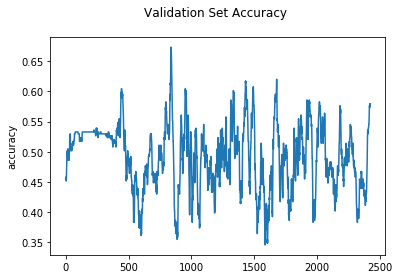

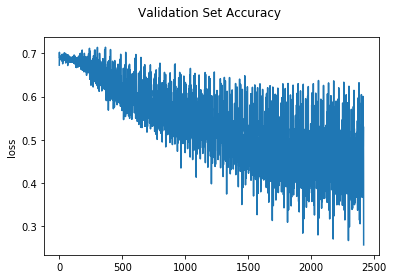

In [25]:
plt.plot(val_acc_training_model)
plt.ylabel('accuracy')
plt.title('Validation Set Accuracy \n')
plt.show()
plt.plot(loss_training_model)
plt.ylabel('loss')
plt.title('Validation Set Accuracy \n')
plt.show()

In [306]:
loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, save_model_path)

    # Get Tensors from loaded model
    loaded_x = loaded_graph.get_tensor_by_name('x:0')
    loaded_y = loaded_graph.get_tensor_by_name('y:0')
    loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
    loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
    loaded_predicted = loaded_graph.get_tensor_by_name('predicted:0')
        

    # Print Random Samples
    random_test_features, random_test_labels = X_val[0:10],y_val[0:10]
    random_test_predictions = sess.run(loaded_predicted,
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
    pred_logits = sess.run(loaded_logits,
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})

INFO:tensorflow:Restoring parameters from ./image_classification


In [307]:
random_test_predictions

array([[ 0.60307008,  0.39692995],
       [ 0.5179739 ,  0.48202613],
       [ 0.5393433 ,  0.4606567 ],
       [ 0.54745072,  0.45254925],
       [ 0.55235255,  0.44764745],
       [ 0.55525178,  0.44474825],
       [ 0.49892527,  0.50107479],
       [ 0.50428671,  0.49571329],
       [ 0.53144062,  0.46855935],
       [ 0.53262049,  0.46737942]], dtype=float32)

In [232]:
pred_logits

array([[-0.27137339, -0.25448743],
       [ 3.38726234,  3.41984892],
       [-0.05805528,  0.12501624],
       [-1.18535817, -1.17084587],
       [-0.24225336, -0.33114657],
       [ 1.77118003,  1.7741195 ],
       [ 0.53766096,  0.54974997],
       [-1.1956948 , -1.17804134],
       [ 2.10083342,  1.86441827],
       [-0.1940189 , -0.26822987]], dtype=float32)

In [308]:
y_val[0:10]

array([[1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1]])

## MODEL 2
------------------

In [71]:
def conv_layer(prev_layer, layer_depth, is_training):
    """
    Create a convolutional layer with the given layer as input.
    
    :param prev_layer: Tensor
        The Tensor that acts as input into this layer
    :param layer_depth: int
        We'll set the strides and number of feature maps based on the layer's depth in the network.
        This is *not* a good way to make a CNN, but it helps us create this example with very little code.
    :param is_training: bool or Tensor
        Indicates whether or not the network is currently training, which tells the batch normalization
        layer whether or not it should update or use its population statistics.
    :returns Tensor
        A new convolutional layer
    """
    strides = 2 if layer_depth % 3 == 0 else 1
    conv_layer = tf.layers.conv2d(prev_layer, layer_depth*4, 3, strides, 'same', use_bias=False, activation=None)
    conv_layer = tf.layers.batch_normalization(conv_layer, training=is_training)
    conv_layer = tf.nn.relu(conv_layer)

    return conv_layer

def fully_connected(prev_layer, num_units, is_training):
    """
    Create a fully connectd layer with the given layer as input and the given number of neurons.
    
    :param prev_layer: Tensor
        The Tensor that acts as input into this layer
    :param num_units: int
        The size of the layer. That is, the number of units, nodes, or neurons.
    :param is_training: bool or Tensor
        Indicates whether or not the network is currently training, which tells the batch normalization
        layer whether or not it should update or use its population statistics.
    :returns Tensor
        A new fully connected layer
    """
    layer = tf.layers.dense(prev_layer, num_units, use_bias=False, activation=None)
    layer = tf.layers.batch_normalization(layer, training=is_training)
    layer = tf.nn.relu(layer)
    return layer

def train(epoches, batch_size, learning_rate,X_train_augmented, y_train_augmented, X_val_augmented,y_val_augmented):
    num_examples = len(X_train_augmented)

    # Build placeholders for the input samples and labels 
    inputs = tf.placeholder(tf.float32, [None, 75, 75, 3])
    labels = tf.placeholder(tf.float32, [None, 2])
    
    
    # Add placeholder to indicate whether or not we're training the model
    is_training = tf.placeholder(tf.bool)

    # Feed the inputs into a series of 20 convolutional layers 
    layer = inputs
    for layer_i in range(1, 20):
        layer = conv_layer(layer, layer_i, is_training)

    # Flatten the output from the convolutional layers 
    orig_shape = layer.get_shape().as_list()
    layer = tf.reshape(layer, shape=[-1, orig_shape[1] * orig_shape[2] * orig_shape[3]])

    # Add one fully connected layer
    layer = fully_connected(layer, 100, is_training)

    # Create the output layer with 1 node for each class
    logits = tf.layers.dense(layer, 2)

    predicted = tf.nn.softmax(logits, name= 'predicted')

    # Define loss and training operations
    model_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    
    # Tell TensorFlow to update the population statistics while training
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_opt = tf.train.AdamOptimizer(learning_rate).minimize(model_loss)
    
    # Create operations to test accuracy
    correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1)) #tf.argmax(labels,1)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # Train and test the network
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for batch_i in range(epoches):
            X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented)
            for offset in range(0, num_examples, batch_size):
                end = offset + batch_size
                batch_xs, batch_ys = X_train_augmented[offset:end], y_train_augmented[offset:end]
 
                # train this batch
                sess.run(train_opt, {inputs: batch_xs, labels: batch_ys, is_training: True})
            
            # Periodically check the validation or training loss and accuracy
            if batch_i % 5 == 0:
                loss, acc = sess.run([model_loss, accuracy], {inputs: X_train_augmented,
                                                              labels: y_train_augmented,
                                                              is_training: False})
                print('Batch: {:>2}: Validation loss: {:>3.5f}, Validation accuracy: {:>3.5f}'.format(batch_i, loss, acc))
            elif batch_i % 25 == 0:
                loss, acc = sess.run([model_loss, accuracy], {inputs: batch_xs, labels: batch_ys, is_training: False})
                print('Batch: {:>2}: Training loss: {:>3.5f}, Training accuracy: {:>3.5f}'.format(batch_i, loss, acc))

        # At the end, score the final accuracy for both the validation and test sets
        acc = sess.run(accuracy, {inputs: X_val_augmented,
                                  labels: y_val_augmented, 
                                  is_training: False})
        print('Final validation accuracy: {:>3.5f}'.format(acc))
        
        # Score the first 100 test images individually, just to make sure batch normalization really worked
        correct = 0
        for i in range(100):
            correct += sess.run(accuracy,feed_dict={inputs: [X_val_augmented[i]],
                                                    labels: [y_val_augmented[i]],
                                                    is_training: False})

        print("Accuracy on 100 samples:", correct/100)
        # Save Model
        saver = tf.train.Saver()
        save_path = saver.save(sess, save_model_path)  


epoches = 200
batch_size = 64
learning_rate = 0.002

tf.reset_default_graph()
with tf.Graph().as_default():
    train(epoches, batch_size, learning_rate, X_train_augmented, y_train_augmented, X_val_augmented,y_val_augmented)

Batch:  0: Validation loss: 0.73890, Validation accuracy: 0.53702
Batch:  5: Validation loss: 2.35473, Validation accuracy: 0.60717
Batch: 10: Validation loss: 0.20655, Validation accuracy: 0.93141
Batch: 15: Validation loss: 0.96490, Validation accuracy: 0.80930
Batch: 20: Validation loss: 2.02032, Validation accuracy: 0.63731
Batch: 25: Validation loss: 0.24414, Validation accuracy: 0.91115
Batch: 30: Validation loss: 4.94643, Validation accuracy: 0.53572
Batch: 35: Validation loss: 0.09395, Validation accuracy: 0.96960
Batch: 40: Validation loss: 0.04429, Validation accuracy: 0.98233
Batch: 45: Validation loss: 0.12137, Validation accuracy: 0.95895
Batch: 50: Validation loss: 0.18650, Validation accuracy: 0.95947
Batch: 55: Validation loss: 0.01451, Validation accuracy: 0.99532
Batch: 60: Validation loss: 0.06038, Validation accuracy: 0.97844
Batch: 65: Validation loss: 0.01144, Validation accuracy: 0.99714
Batch: 70: Validation loss: 0.03461, Validation accuracy: 0.98857
Batch: 75:

### MODEL 3, using keras
------------------

In [ ]:
ref https://www.kaggle.com/knowledgegrappler/a-keras-prototype-0-21174-on-pl

In [74]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping


Using TensorFlow backend.


In [130]:
def get_callbacks(filepath, patience=5):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def get_model():
    bn_model = 0
    p_activation = "elu"
    input_1 = Input(shape=(75, 75, 3), name="X_1")
    input_2 = Input(shape=[1], name="angle")
    
    img_1 = Conv2D(16, kernel_size = (3,3), activation=p_activation) ((BatchNormalization(momentum=bn_model))(input_1))
    img_1 = Conv2D(16, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(32, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = Conv2D(32, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(128, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = GlobalMaxPooling2D() (img_1)
    
    
    img_2 = Conv2D(128, kernel_size = (3,3), activation=p_activation) ((BatchNormalization(momentum=bn_model))(input_1))
    img_2 = MaxPooling2D((2,2)) (img_2)
    img_2 = Dropout(0.2)(img_2)
    img_2 = GlobalMaxPooling2D() (img_2)
    
    img_concat =  (Concatenate()([img_1, img_2, BatchNormalization(momentum=bn_model)(input_2)]))
    
    dense_ayer = Dropout(0.5) (BatchNormalization(momentum=bn_model) ( Dense(256, activation=p_activation)(img_concat) ))
    dense_ayer = Dropout(0.5) (BatchNormalization(momentum=bn_model) ( Dense(64, activation=p_activation)(dense_ayer) ))
    output = Dense(1, activation="sigmoid")(dense_ayer)
    
    model = Model([input_1,input_2],  output)
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model
model = get_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_1 (InputLayer)                (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 75, 75, 3)    12          X_1[0][0]                        
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 73, 73, 16)   448         batch_normalization_26[0][0]     
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 71, 71, 16)   2320        conv2d_41[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [131]:
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

model = get_model()
history = model.fit([X_train_augmented, X_angle_train_augmented], y_train_augmented, epochs=25, 
          validation_data=([X_val, X_angle_val], y_val) , batch_size=32, callbacks=callbacks, verbose = 1)
print(history.history)

Train on 3849 samples, validate on 321 samples
Epoch 1/25
3849/3849 [==============================] - 109s 28ms/step - loss: 0.6493 - acc: 0.7046 - val_loss: 0.6895 - val_acc: 0.6760
Epoch 2/25
3849/3849 [==============================] - 101s 26ms/step - loss: 0.4841 - acc: 0.7867 - val_loss: 0.3568 - val_acc: 0.8660
Epoch 3/25
3849/3849 [==============================] - 100s 26ms/step - loss: 0.4098 - acc: 0.8246 - val_loss: 0.4247 - val_acc: 0.8411
Epoch 4/25
3849/3849 [==============================] - 101s 26ms/step - loss: 0.3714 - acc: 0.8376 - val_loss: 1.2100 - val_acc: 0.5639
Epoch 5/25
3849/3849 [==============================] - 102s 27ms/step - loss: 0.3268 - acc: 0.8529 - val_loss: 0.9403 - val_acc: 0.8536
Epoch 6/25
3849/3849 [==============================] - 103s 27ms/step - loss: 0.3212 - acc: 0.8597 - val_loss: 0.5650 - val_acc: 0.8411
Epoch 7/25
3849/3849 [==============================] - 100s 26ms/step - loss: 0.3083 - acc: 0.8639 - val_loss: 0.2733 - val_acc: 0

In [132]:
model.load_weights(filepath=file_path)

print("Train evaluate, returns taining loss & accuracy:")
print(model.evaluate([X_train, X_angle_train], y_train, verbose=1, batch_size=200))
print("####################")
print("watch list evaluate, returns validation loss & accuracy:")
print(model.evaluate([X_val, X_angle_val], y_val, verbose=1, batch_size=200))

Train evaluate, returns taining loss & accuracy:
1283/1283 [==============================] - 9s 7ms/step
[0.15728960804124409, 0.93998440303378805]
####################
watch list evaluate, returns validation loss & accuracy:
321/321 [==============================] - 2s 8ms/step
[0.23648688331757009, 0.91900310189553136]


In [133]:
## EVALUATE PREDICTIONS FOR V_val
prediction_val = model.predict([X_val, X_angle_val], verbose=1, batch_size=200)

321/321 [==============================] - 3s 8ms/step


In [134]:
#list( zip(prediction_val.T, np.round(prediction_val.T)))
np.dstack((prediction_val.T,np.round(prediction_val.T), y_val)).shape

(1, 321, 3)

In [135]:
# Calculate accuracy (manually) for the validation set
comp = np.reshape(np.dstack((prediction_val.T,np.round(prediction_val.T), y_val)),(321,3))
1- np.sum(np.abs(comp[:,1]-comp[:,2])) / len(comp)

0.9190031152647975

### Preparate submission

In [137]:
data_dir = './data'
test_json = data_dir+'/test.json'
test = pd.read_json(test_json)
test.shape

(8424, 4)

In [138]:
## Preprocess test data set and prepare features: 
#  y_test should be empty
X_test, X_angle_test, y_test = process_data(test, False)

Training mode: False
Num initial observations in the dataset:  8424
Len for processed datasets:  8424 0 (75, 75, 3)
Returning data for test dataset


In [144]:
## Calculate prediction
prediction = model.predict([X_test, X_angle_test], verbose=1, batch_size=200)

8424/8424 [==============================] - 63s 7ms/step


In [146]:
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})
submission.head(10)

,id,is_iceberg
0,5941774d,0.023929
1,4023181e,0.000387
2,b20200e4,0.000219
3,e7f018bb,0.996021
4,4371c8c3,0.001344
5,a8d9b1fd,0.764947
6,29e7727e,0.136885
7,92a51ffb,0.986647
8,c769ac97,0.017553
9,aee0547d,0.002959


In [153]:
prediction[0][0]

0.023929169

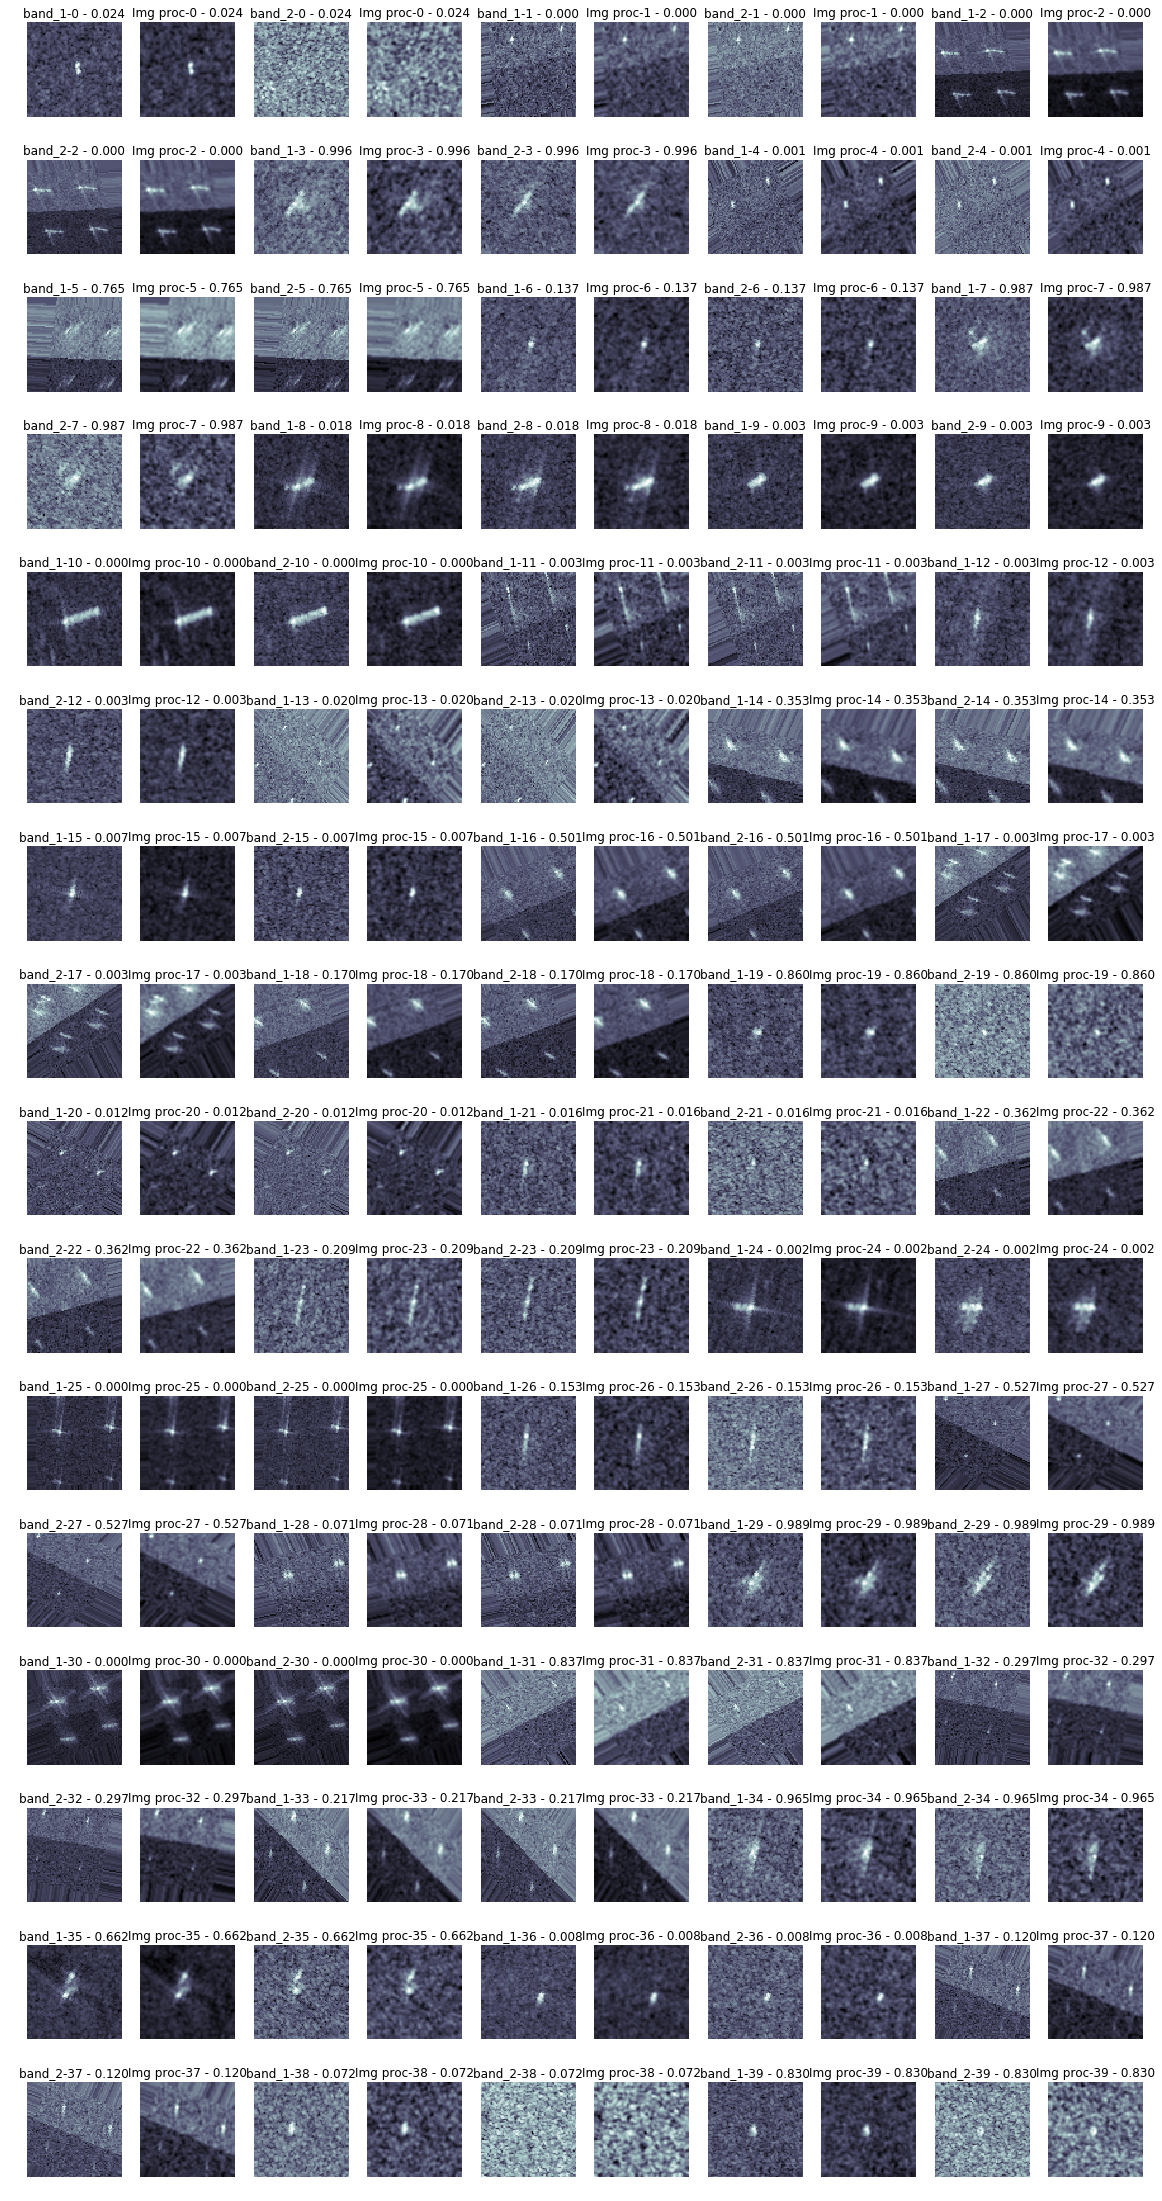

In [169]:
## Visualize some examples:
#--------------------------
# pred is  the predicted probability that the image contains an iceberg. 1 means th eimage contains some iceberg.
# Plot test EXAMPLES
rows = 8
pics = 5
pic = 0
fig = plt.figure(figsize=(20,40) )
#fig, axes = plt.subplots(rows,2, figsize=(15,15))

for i in range(rows*pics):
    pred = prediction[i][0]
    
    # band_1
    pic = pic +1
    ax = fig.add_subplot(rows*2,pics*2,pic)
    ax.set_axis_off()
    arr = np.reshape(np.array(test.iloc[i,0]),(75,75))
    ax.set_title('band_1-{ind} - {pred:.3f}'.format(ind = i, pred = pred))  
    ax.imshow(arr, cmap = 'bone') # inferno, viridis, bone, gist_heat

    # Image processed
    pic = pic+1
    ax = fig.add_subplot(rows*2,pics*2,pic)
    ax.set_axis_off()
    result =  image_preprocessing(arr)
    #arr = np.reshape(np.array(train_iceberg.iloc[i,1]),(75,75))
    ax.set_title('Img proc-{ind} - {pred:.3f}'.format(ind = i, pred = pred)) 
    ax.imshow(result,cmap='bone')

    # band_2
    pic = pic+1
    ax = fig.add_subplot(rows*2,pics*2,pic)
    ax.set_axis_off()
    arr = np.reshape(np.array(test.iloc[i,1]),(75,75))
    ax.set_title('band_2-{ind} - {pred:.3f}'.format(ind = i, pred = pred)) 
    ax.imshow(arr,cmap='bone')

    # Image processed band_2
    pic = pic+1
    ax = fig.add_subplot(rows*2,pics*2,pic)
    ax.set_axis_off()
    result =  image_preprocessing(arr)
    ax.set_title('Img proc-{ind} - {pred:.3f}'.format(ind = i, pred = pred)) 
    ax.imshow(result,cmap='bone')
plt.show()


Submission File
For each id in the test set, you must predict the probability that the image contains an iceberg (a number between 0 and 1). The file should contain a header and have the following format:

id,is_iceberg
809385f7,0.5
7535f0cd,0.4
3aa99a38,0.9
etc.

In [166]:
submission.tail()

,id,is_iceberg
8419,16ee9b50,0.000407
8420,5a599eb7,0.000032
8421,df30d6dd,0.035238
8422,18af95b1,0.997884
8423,27d788c8,0.000037


In [165]:
submission.to_csv('./submission1.csv', sep=',', header=True, index = False)

### Test the model

In [161]:
data_dir = './data'
test_json = data_dir+'/test.json'
test = pd.read_json(test_json)

In [162]:
test.shape

(8424, 4)

In [164]:
test.head()

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.172482, -15.443275, -14.011121, -16.124729, -17.779478, -19.42761, -18.219221, -17.463379, -20.242298, -17.672544, -16.394279, -16.672922, -15.948608, -17.058884, -14.292757, -11.704641, -12.661265, -16.863401, -15.360503, -14.292401, -14.58432, -16.960165, -18.681437, -16.578163, -15.861324, -15.360004, -15.690865, -17.359159, -19.42597, -17.257425, -14.809227, -15.606586, -16.484625, -16.484625, -17.057457, -15.119185, -15.946968, -17.994354, -17.057173, -17.156368, -14.582966, -12.367072, -12.600193, -12.600121, -14.29069, -14.884757, -15.68951, -15.605516, -15.946112, -18.444817, -16.121449, -14.434958, -16.300404, -17.357378, -18.329412, -20.09778, -16.860691, -17.155087, -19.554522, -20.981567, -16.4827, -14.147083, -14.361488, -15.521257, -16.860121, -16.482344, -15.03837, -14.361134, -17.055033, -14.146514, -12.898778, -14.006273, -16.395206, -15.201077, -16.395063, -17.996922, -15.777389, -14.735364, -15.443133, -17.059525, -17.887...","[-21.629612, -21.142353, -23.908337, -28.34524, -27.006233, -25.846321, -22.507294, -23.080124, -23.907907, -24.585001, -23.07991, -23.079838, -22.506865, -22.693594, -25.067318, -25.319031, -27.005375, -23.692787, -23.279026, -24.35265, -23.483265, -23.483192, -23.079054, -22.144115, -22.506008, -23.278524, -22.883572, -23.906551, -20.679121, -21.796206, -25.317959, -29.099014, -27.32012, -25.844324, -24.583218, -25.5769, -25.5769, -26.119877, -24.583004, -25.065605, -23.077843, -22.504868, -24.351082, -25.576403, -25.843611, -25.065178, -24.350796, -26.119164, -25.576048, -22.882004, -21.626117999999998, -21.460594, -23.690365, -24.124678, -24.581863, -25.575546, -26.697796, -22.881433, -20.828115, -22.690384, -27.646004, -28.341175, -27.318054, -22.690102, -20.38216, -21.625046, -24.349369, -23.903772, -25.574623, -26.402405, -26.117525, -25.063326, -23.479631, -24.123251, -26.40205, -20.985918, -21.142353, -26.701574, -25.579185, -25.068033, -26.122089, -22.694094, -21.969778,...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26.058969497680664, -22.74645233154297, -22.74645233154297, -22.33283805847168, -21.747129440307617, -21.747129440307617, -25.175128936767578, -21.377613067626953, -21.560558319091797, -24.121231079101562, -23.876619338989258, -28.558361053466797, -23.876811981201172, -24.899940490722656, -23.876930236816406, -23.639020919799805, -24.373554229736328, -20.851806640625, -26.376052856445312, -23.87735366821289, -22.134428024291992, -24.373979568481445, -24.373979568481445, -24.900636672973633, -23.639677047729492, -25.46136474609375, -25.755905151367188, -28.98334503173828, -29.4289493560791, -24.122737884521484, -25.176942825317383, -22.13520050048828, -22.539344787597656, -22.96320915222168, -24.123125076293945, -22.135507583618164, -24.634361267089844, -27.045917510986328, -27.045917510986328, -23.87874412536621, -22.539884567260742, -20.197694778442383, -24.902027130126953, -27.398059844970703, -25.459936141967773, -24.121076583862305, ...","[-25.754207611083984, -25.754207611083984, -25.754207611083984, -21.747013092041016, -21.747013092041016, -23.63821029663086, -26.37504768371582, -26.37504768371582, -20.516881942749023, -21.7473201751709, -22.746877670288086, -24.12126922607422, -27.398483276367188, -26.05962562561035, -22.747222900390625, -24.899940490722656, -22.74734115600586, -25.75513458251953, -21.748016357421875, -21.561290740966797, -26.703895568847656, -22.747764587402344, -22.747840881347656, -25.75563621520996, -25.75563621520996, -24.374095916748047, -25.176517486572266, -26.704360961914062, -25.176673889160156, -31.482158660888672, -24.90106201171875, -25.75617790222168, -25.17698097229004, -20.852888107299805, -22.539384841918945, -23.640411376953125, -25.177289962768555, -24.375022888183594, -25.177444458007812, -24.901756286621094, -24.901756286621094, -22.963634490966797, -22.13585662841797, -23.409317016601562, -26.374969482421875, -27.7677650451

In [177]:
loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, save_model_path)

    # Get Tensors from loaded model
    loaded_x = loaded_graph.get_tensor_by_name('x:0')
    loaded_y = loaded_graph.get_tensor_by_name('y:0')
    loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
    loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
    predicted = loaded_graph.get_tensor_by_name('predicted:0')
        

    # Print Random Samples
    random_test_features, random_test_labels = X_val[0:10],y_val[0:10]
    random_test_predictions = sess.run(
            tf.nn.softmax(loaded_logits),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
    

INFO:tensorflow:Restoring parameters from ./image_classification


In [171]:
X_val[0:10],y_val[0:10]

(array([[[[  75.25215683,  124.58003629],
          [  82.63508071,  118.85876846],
          [  94.00611965,  108.90198513],
          ..., 
          [ 101.86345583,  160.61532306],
          [ 115.01670245,  161.45264266],
          [ 118.69031792,  164.25594889]],
 
         [[  79.3570068 ,  117.01341286],
          [  84.31437308,  112.07241886],
          [  92.87372555,  108.19770138],
          ..., 
          [ 101.8858231 ,  156.98362426],
          [ 116.74252056,  160.16536109],
          [ 122.53180539,  163.71950015]],
 
         [[  91.9164894 ,  112.83401207],
          [  91.11945875,  109.86768338],
          [  89.19254136,  116.60891933],
          ..., 
          [ 100.72483808,  149.56353559],
          [ 116.69706432,  156.70863797],
          [ 124.74297748,  160.66346002]],
 
         ..., 
         [[  97.77943248,  109.51758629],
          [  90.43993196,  108.28631301],
          [  79.57392246,  115.71356536],
          ..., 
          [ 106.12680067,  133

In [178]:
random_test_predictions

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]], dtype=float32)

In [179]:
y_train

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [180]:
y_val

array([1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1,